# DSA5101 Project: Understanding Pokémon through Networks and Clustering
##### *By: Wong Li Sum (A0298284L)*
In this project, the Pokémon dataset is used to explore the type dynamics and character profiles among the Pokémon.

1. This project attempt to analyse the interactions for attack and defense among the different Pokémon types. Nodes importance in the networks are calculated using PageRank and topic-specific (personalized) PageRank to identify key Pokémon types in the attack and defense network. 

2.  This project also attempt to cluster Pokémon based on various core features including biometric attributes, battle stats and non-combat attributes. Dimensionality reduction using Singular Vector Decomposition (SVD) is first applied on the selected features, followed by clustering using algorithms such as K-means clustering and hierarchical cluster to uncover the major grouping of Pokémon.

In [1]:
# Install packages
# !pip install scikit-network
# !pip install networkx
# !pip install kneed

In [2]:
# Load libraries
## for data manipulation and dataframes
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for network analysis
import networkx as nx 
from sknetwork.ranking import PageRank

# for standardizing data and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

## for clustering
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster    

# for chi-sq test
from scipy.stats import chi2_contingency

## Dataset
### Load dataset

In [3]:
# Load data
raw_df = pd.read_csv('pokemon_data.csv')

In [4]:
# Select only required columns
df = raw_df.iloc[:,np.r_[0:22,24:28,29:37,39]]
df.head()

,pokedex_number,name,type1,type2,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fighting,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,height_m,weight_kg,capture_rate,base_egg_steps,experience_growth,base_happiness,hp,attack,defense,sp_attack,sp_defense,speed,is_legendary
0,1,Bulbasaur,grass,poison,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,0.7,6.9,45,5120,1059860,70,45,49,49,65,65,45,0
1,2,Ivysaur,grass,poison,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,1.0,13.0,45,5120,1059860,70,60,62,63,80,80,60,0
2,3,Venusaur,grass,poison,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,2.0,100.0,45,5120,1059860,70,80,100,123,122,120,80,0
3,4,Charmander,fire,NaN,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,0.6,8.5,45,5120,1059860,70,39,52,43,60,50,65,0
4,5,Charmeleon,fire,NaN,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,1.1,19.0,45,5120,1059860,70,58,64,58,80,65,80,0


In [5]:
# Clean the type field
df.loc[df['type1'] == df['type2'], 'type2'] = np.nan

### Analysis on core features
Core features includes biometric attributes such as height and weight, non-combat attributes such as capture rate, base egg steps, experience growth and base happiness and battle stats such as hp, attack, defense, special attack, special defense and speed.

In [6]:
# Descriptive Statistics
features = df.iloc[:,22:34]
features.describe() 

,height_m,weight_kg,capture_rate,base_egg_steps,experience_growth,base_happiness,hp,attack,defense,sp_attack,sp_defense,speed
count,801.000000,801.000000,801.000000,801.000000,8.010000e+02,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,1.155556,60.941199,98.956305,7191.011236,1.054996e+06,65.362047,68.958801,77.857678,73.008739,71.305868,70.911361,66.334582
std,1.069952,108.514597,76.409828,6558.220422,1.602558e+05,19.598948,26.576015,32.158820,30.769159,32.353826,27.942501,28.907662
min,0.100000,0.100000,3.000000,1280.000000,6.000000e+05,0.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,0.600000,9.000000,45.000000,5120.000000,1.000000e+06,70.000000,50.000000,55.000000,50.000000,45.000000,50.000000,45.000000
50%,1.000000,27.300000,60.000000,5120.000000,1.000000e+06,70.000000,65.000000,75.000000,70.000000,65.000000,66.000000,65.000000
75%,1.500000,63.000000,170.000000,6400.000000,1.059860e+06,70.000000,80.000000,100.000000,90.000000,91.000000,90.000000,85.000000
max,14.500000,999.900000,255.000000,30720.000000,1.640000e+06,140.000000,255.000000,185.000000,230.000000,194.000000,230.000000,180.000000


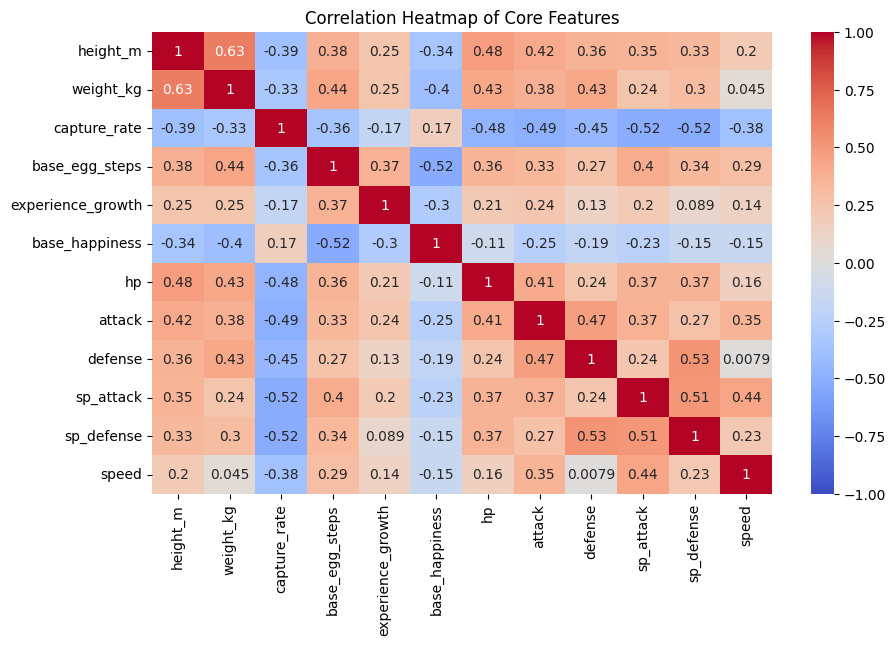

In [7]:
# Correlation heatmap of core features
correlation = features.astype(float).corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1, )
plt.title("Correlation Heatmap of Core Features")
plt.show()

### Analysis on Pokémon type
Pokémon can be single or dual type. Only dual-type Pokémon will have a secondary type.

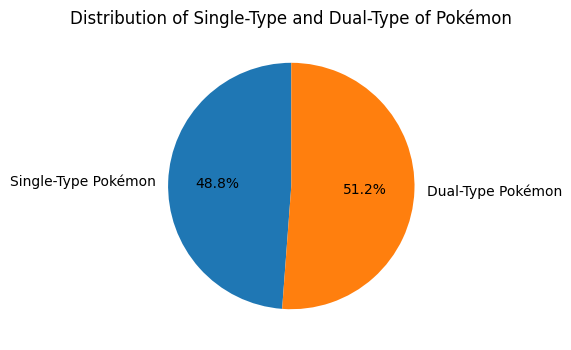

In [8]:
# Count the number of single-type and dual-type Pokémon
single_type_count = df[df['type2'].isnull()].shape[0]
dual_type_count = df[df['type2'].notnull()].shape[0]

# Plot pie chart
plt.figure(figsize=(8, 4))
plt.pie([single_type_count, dual_type_count], 
        labels=['Single-Type Pokémon', 'Dual-Type Pokémon'], 
        autopct='%1.1f%%',  
        startangle=90)
plt.title('Distribution of Single-Type and Dual-Type of Pokémon')
plt.show()

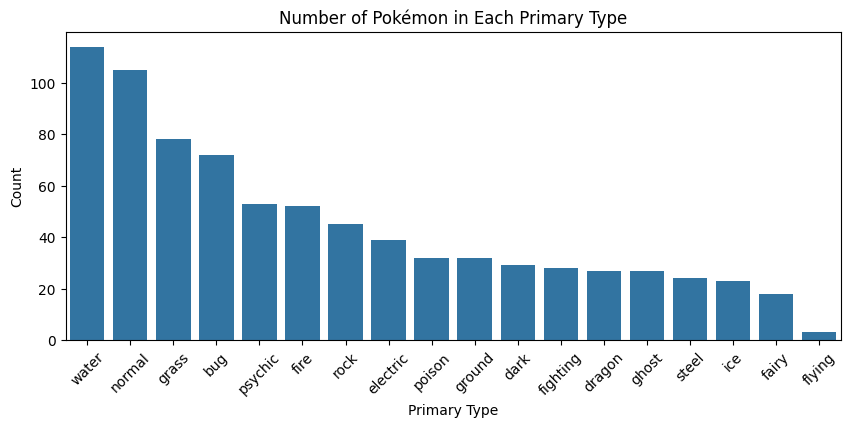

In [9]:
# Count the number of Pokémon in each primary type
type_counts = df['type1'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 4))
sns.barplot(type_counts)
plt.title('Number of Pokémon in Each Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

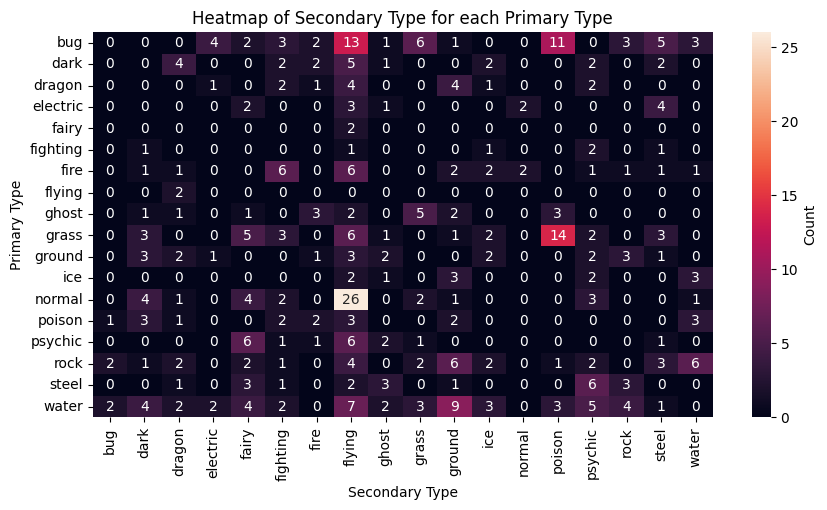

In [10]:
# Count the number of Pokemon in each secondary type for each primary type
type_counts = df.groupby('type1')['type2'].value_counts().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(type_counts, annot=True, fmt='d', cbar_kws={'label': 'Count'})
plt.title('Heatmap of Secondary Type for each Primary Type')
plt.xlabel('Secondary Type')
plt.ylabel('Primary Type')
plt.show()

## Network Analysis on Pokémon Type Interactions
We will focus on single-type Pokémon to simplify the analysis of type interactions, as their strengths and weaknesses are more straightforward. The analysis covers both attack and defense scenarios using the against_? variable, which represents the damage multipliers a Pokémon takes when attacked by a specific type.

The against_? variables are interpreted as follows:
*	Value < 1: Less damage than usual, suggesting the Pokémon’s type defends well against that particular type.
*	Value = 1: Normal damage, suggesting neutral interaction where the type neither effectively defends nor is particularly vulnerable to that particular type.
*	Value > 1: More damage than usual, suggesting the type is more vulnerable to attack from that particular type. Conversely, this suggests an attacking ability for the attacking type.


In [11]:
# Get the damage against the different types for each primary type (among single-type Pokémon only)
primary_df = df[df['type2'].isna()].iloc[:,2:22]
primary_df = primary_df.drop_duplicates().drop("type2", axis = 1)
primary_df.columns = primary_df.columns.str.replace("against_", "", regex=False)
primary_df = primary_df.sort_values("type1").set_index("type1")
primary_df

,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water
type1,,,,,,,,,,,,,,,,,,
bug,1.0,1.0,1.0,1.0,1.0,0.5,2.0,2.0,1.0,0.5,0.5,1.0,1.0,1.0,1.0,2.0,1.0,1.0
dark,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
dragon,1.0,1.0,2.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5
electric,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
fairy,0.5,0.5,0.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0
fighting,0.5,0.5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0
fire,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
flying,0.5,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0,0.5,0.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
ghost,0.5,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.5,1.0,1.0,1.0,1.0


## Attack Scenario
### Construct network graph
Analyzes type interactions where the against_? value is greater than 1, indicating effective attack relationships. Nodes represent Pokémon types, and directed edges show effective attack interactions (e.g., Fire → Water indicates Fire effectively attacks by Water). Node size reflects the proportion of Pokémon in each type, with larger nodes representing more common types.

In [12]:
# Get the weights, which is the proportion of number of Pokémon in each type
primary_count = df[df['type2'].isna()]['type1'].value_counts()
weight = primary_count / sum(primary_count)
weight_dict = weight.to_dict()
index_name_dict = {i: label for i, label in enumerate(primary_df.index)}
matched_weights = {index: weight_dict.get(type_name, 0) for index, type_name in index_name_dict.items()}

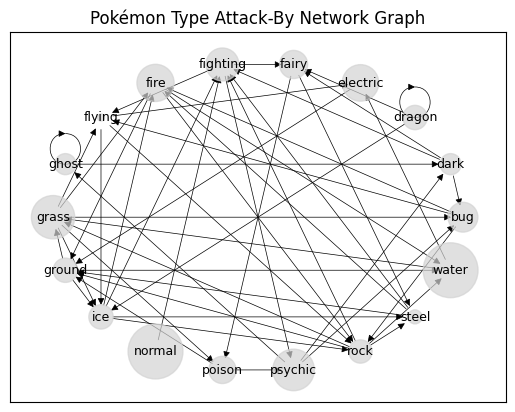

In [13]:
# Determine attackers
primary_df_attack =  primary_df.map(lambda x: 1 if x >1 else 0 )

# Plot network graph
G_attack = nx.DiGraph(primary_df_attack.values)

pos = nx.circular_layout(G_attack)
node_sizes = np.array(list(matched_weights.values())) * 10000 
nx.draw_networkx_nodes(G_attack, pos, node_size=node_sizes, node_color='lightgrey', alpha= 0.7)
nx.draw_networkx_edges(G_attack, pos, arrows=True, width = 0.5)
nx.draw_networkx_labels(G_attack, pos, labels=index_name_dict, font_size=9)
plt.title("Pokémon Type Attack-By Network Graph")
plt.show()

### Compute Pokémon type interaction metrics
Use PageRank and topic-specific (personalized) PageRank to measure the influence of each Pokémon type in the attack network.

In [14]:
# Calculate number of in-links and out-links
in_links = {node: G_attack.in_degree(node) for node in G_attack.nodes()}
out_links = {node: G_attack.out_degree(node) for node in G_attack.nodes()}

# Caluclate pagerank and personalized page rank scores
pagerank_scores = nx.pagerank(G_attack)
personalized_pagerank_scores = nx.pagerank(G_attack, personalization = matched_weights)

# Create dataframe to hold the results
data = {
    'Type': [index_name_dict[node] for node in G_attack.nodes()],
    'Weight': [matched_weights[node] for node in G_attack.nodes()],
    'In-Links': [in_links[node] for node in G_attack.nodes()],
    'Out-Links': [out_links[node] for node in G_attack.nodes()],
    'PageRank': [pagerank_scores[node] for node in G_attack.nodes()],
    'Personalized_PageRank': [personalized_pagerank_scores[node] for node in G_attack.nodes()],
}
attack_df = pd.DataFrame(data).sort_values("Personalized_PageRank", ascending= False)

# Create ranking for the pagerank scores and personalized pagerank scores
attack_df['PR_Rank'] = attack_df['PageRank'].rank(ascending=False)
attack_df['PPR_Rank'] = attack_df['Personalized_PageRank'].rank(ascending=False)
attack_df

,Type,Weight,In-Links,Out-Links,PageRank,Personalized_PageRank,PR_Rank,PPR_Rank
10,ground,0.030691,5,3,0.119862,0.115995,1.0,1.0
9,grass,0.097187,3,5,0.086013,0.095437,2.0,2.0
17,water,0.156010,3,2,0.073821,0.086574,4.0,3.0
5,fighting,0.056266,5,3,0.069849,0.075676,6.0,4.0
11,ice,0.030691,4,4,0.076037,0.070024,3.0,5.0
6,fire,0.071611,4,3,0.067705,0.067434,7.0,6.0
15,rock,0.028133,4,5,0.072614,0.065877,5.0,7.0
3,electric,0.069054,2,1,0.055534,0.061661,9.0,8.0
7,flying,0.002558,3,3,0.055859,0.051210,8.0,9.0
14,psychic,0.089514,2,3,0.045442,0.051117,12.0,10.0


## Defense Scenario
### Construct network graph
Analyzes type interactions where the against_? value is less than 1, indicating effective defense relationships. Nodes represent Pokémon types, and directed edges show effective defense interactions (e.g., Fairy → Poison indicates Poison effectively defends agianst Fairy). Node size reflects the proportion of Pokémon in each type, with larger nodes representing more common types.

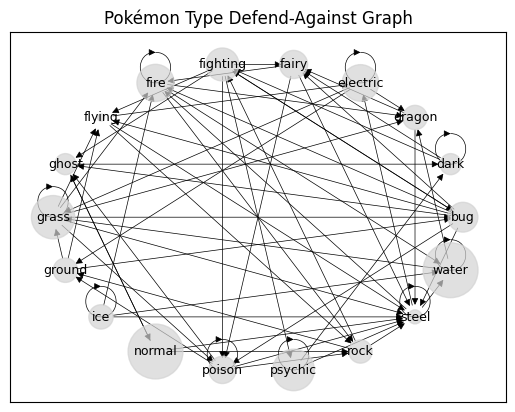

In [15]:
# Determine defenders
primary_df_defend =  primary_df.map(lambda x: 1 if x < 1 else 0 )
primary_df_defend = primary_df_defend.transpose()

# Plot network graph
G_defend = nx.DiGraph(primary_df_defend.values)
nx.draw_networkx_nodes(G_defend, pos, node_size=node_sizes, node_color='lightgrey', alpha= 0.7)
nx.draw_networkx_edges(G_defend, pos, arrows=True, width = 0.5)
nx.draw_networkx_labels(G_defend, pos, labels=index_name_dict, font_size=9)
plt.title("Pokémon Type Defend-Against Graph")
plt.show()

### Compute Pokémon type interaction metrics
Use PageRank and topic-specific (personalized) PageRank to measure the influence of each Pokémon type in the defense network.

In [16]:
# Calculate number of in-links and out-links
in_links = {node: G_defend.in_degree(node) for node in G_defend.nodes()}
out_links = {node: G_defend.out_degree(node) for node in G_defend.nodes()}

# Caluclate pagerank and personalized page rank scores
pagerank_scores = nx.pagerank(G_defend)
personalized_pagerank_scores = nx.pagerank(G_defend, personalization = matched_weights)
    
# Create dataframe to hold the results
data = {
    'Type': [index_name_dict[node] for node in G_defend.nodes()],
    'Weight': [matched_weights[node] for node in G_defend.nodes()],
    'In-Links': [in_links[node] for node in G_defend.nodes()],
    'Out-Links': [out_links[node] for node in G_defend.nodes()],
    'PageRank': [pagerank_scores[node] for node in G_defend.nodes()],
    'Personalized_PageRank': [personalized_pagerank_scores[node] for node in G_defend.nodes()]
}
defend_df = pd.DataFrame(data).sort_values("Personalized_PageRank", ascending=False)

# Create ranking for the pagerank scores and personalized pagerank scores
defend_df['PR_Rank'] = defend_df['PageRank'].rank(ascending=False)
defend_df['PPR_Rank'] = defend_df['Personalized_PageRank'].rank(ascending=False)
defend_df

,Type,Weight,In-Links,Out-Links,PageRank,Personalized_PageRank,PR_Rank,PPR_Rank
16,steel,0.010230,11,4,0.152877,0.146398,1.0,1.0
17,water,0.156010,4,3,0.087631,0.105342,3.0,2.0
6,fire,0.071611,6,4,0.092867,0.092905,2.0,3.0
9,grass,0.097187,4,7,0.068885,0.079267,5.0,4.0
2,dragon,0.030691,4,2,0.075324,0.077371,4.0,5.0
3,electric,0.069054,3,4,0.066182,0.063783,6.0,6.0
4,fairy,0.040921,4,3,0.061349,0.057846,7.0,7.0
15,rock,0.028133,4,3,0.054782,0.051553,8.0,8.0
13,poison,0.038363,5,5,0.052969,0.049421,9.0,9.0
10,ground,0.030691,3,3,0.046923,0.041166,10.0,10.0


# Clustering Pokémon Based on Characteristics
Clustering Pokémon based on core features beyond type, including biometric attributes (height, weight), non-combat attributes (capture rate, base egg steps, experience growth, base happiness), and battle stats (HP, attack, defense, special attack, special defense, speed).

In [17]:
# Selecting the core features
features = df.iloc[:,22:34]
features.head()

,height_m,weight_kg,capture_rate,base_egg_steps,experience_growth,base_happiness,hp,attack,defense,sp_attack,sp_defense,speed
0,0.7,6.9,45,5120,1059860,70,45,49,49,65,65,45
1,1.0,13.0,45,5120,1059860,70,60,62,63,80,80,60
2,2.0,100.0,45,5120,1059860,70,80,100,123,122,120,80
3,0.6,8.5,45,5120,1059860,70,39,52,43,60,50,65
4,1.1,19.0,45,5120,1059860,70,58,64,58,80,65,80


## Standardize and Reduce Dimensionality of the Features

In [18]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

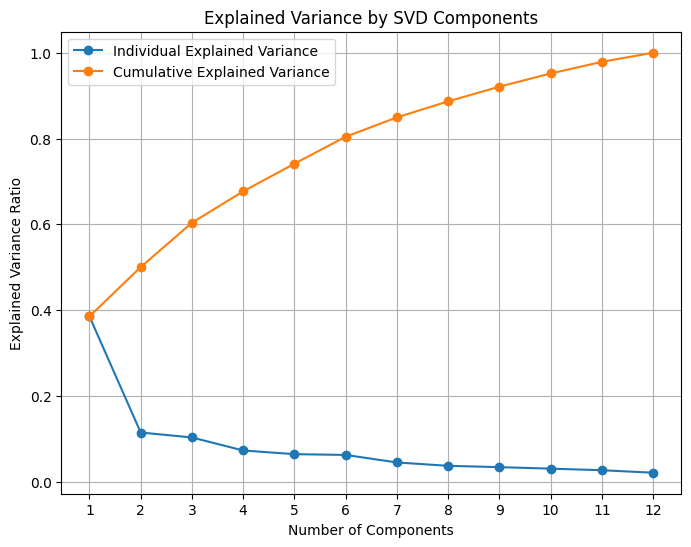

In [19]:
# Perform SVD on the scaled features
svd = TruncatedSVD(n_components=scaled_features.shape[1], random_state=42)
svd.fit(scaled_features)

# Calculate the explained variance ratio
explained_variance = svd.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', label='Cumulative Explained Variance')
plt.title('Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()
plt.show()

In [20]:
# Reduced features with 6 components
svd = TruncatedSVD(n_components=6)
X_reduced6 = svd.fit_transform(scaled_features)

# Reduced features with 2 components
svd = TruncatedSVD(n_components=2)
X_reduced2 = svd.fit_transform(scaled_features)

## K-Means Clustering
### Determine optimal number of clusters
Using the Elbow Method to determine optimal number of clusters, with Wihtin-Cluster Sum of Squares to measure the model's performance.

In [21]:
# Function to plot the Elbow Method
def optimal_k(data):
    # Possible clusters range from 1 to 11
    k_values = range(1, 11)  
    wcss = [] 

    # Compute WCSS for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X_reduced2)
        wcss.append(kmeans.inertia_)

    # Using KneeLocator to find the elbow
    kneedle = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')
    elbow_k = kneedle.elbow

    # Plot the Elbow Method
    plt.figure(figsize=(8,4))
    plt.plot(k_values, wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.xticks(k_values)
    plt.annotate(f"The elbow point is at k = {elbow_k}.",xy=(5,3500))
    plt.grid()
    plt.show()

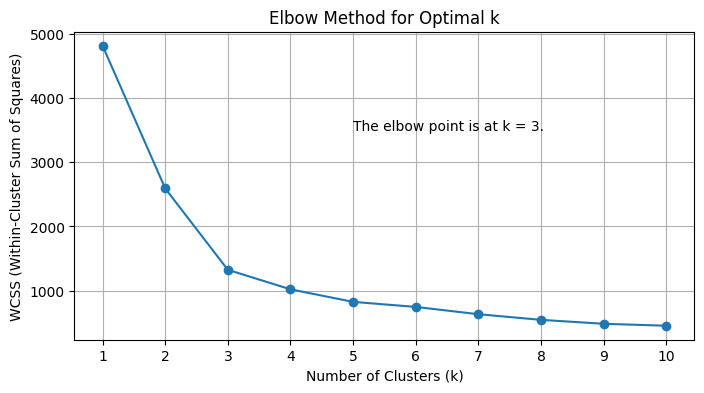

In [22]:
# Determine optimal k for the different dimensions of features
# optimal_k(scaled_features)
# optimal_k(X_reduced6)
optimal_k(X_reduced2) # similar result for all

### Fitting K-Means clustering
Using Silhouette score to to compare clustering quality for fitting with the differest set of features.

In [23]:
# To fit K-Means Clustering and compute the Silhouette score on the 3 sets
datasets = [("scaled_features", scaled_features), 
            ("X_reduced6", X_reduced6), 
            ("X_reduced2", X_reduced2)]

for name, data in datasets:
    # Perform K-Means Clustering
    kmeans = KMeans(n_clusters=3, random_state=123)
    kmeans_clusters = kmeans.fit_predict(data)

    # Compute the Silhoutte score
    score = silhouette_score(data, kmeans_clusters)
    print (f"The Silhouette score for {name} set is {score}.")  

The Silhouette score for scaled_features set is 0.23296676621548218.
The Silhouette score for X_reduced6 set is 0.2974332235571188.
The Silhouette score for X_reduced2 set is 0.5127004913574307.


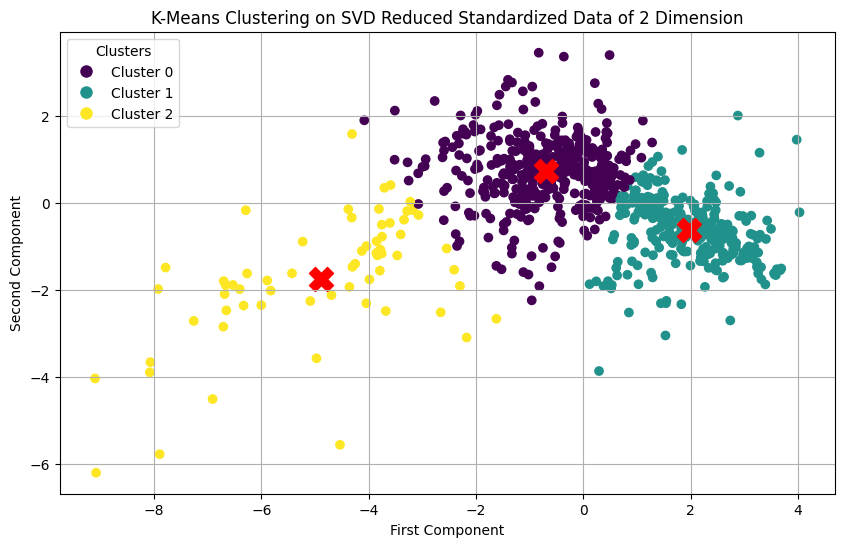

In [24]:
# Plot the scatterplot with the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=kmeans_clusters, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=300, label='Centroids')

handles = []
for i in range(3):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                   markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10))

plt.title('K-Means Clustering on SVD Reduced Standardized Data of 2 Dimension')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

## Hierarchical CLustering
We will fit agglomerative hierarchical clustering on the reduced standardized features in 2 dimensions directly.

### Fitting agglomerative hierarchical clustering

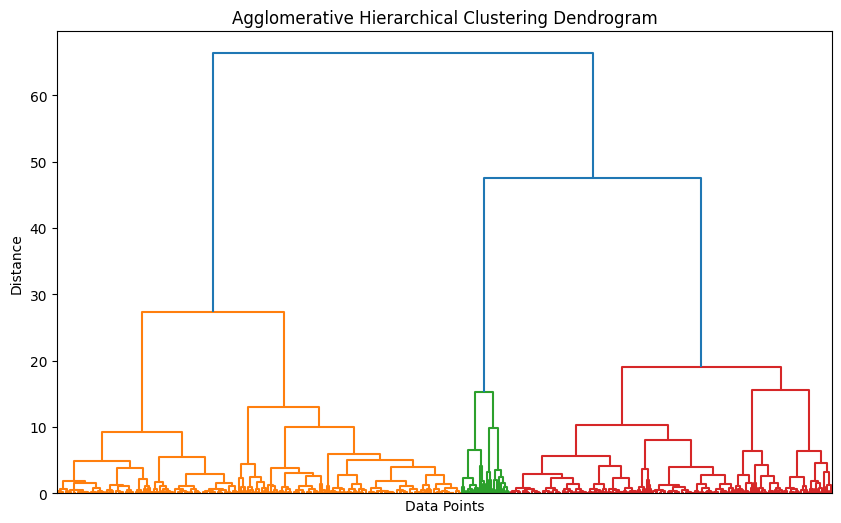

In [25]:
# Create linkage matrix using Ward's linkage
linkage_matrix = linkage(X_reduced2, method='ward')  

# Plot dendogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix, no_labels=True)
plt.title("Agglomerative Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [26]:
# Form cluster based on cutoff distance
cutoff_distance = 30 
hierarchical_cluster = fcluster(linkage_matrix, cutoff_distance, criterion='distance') - 1

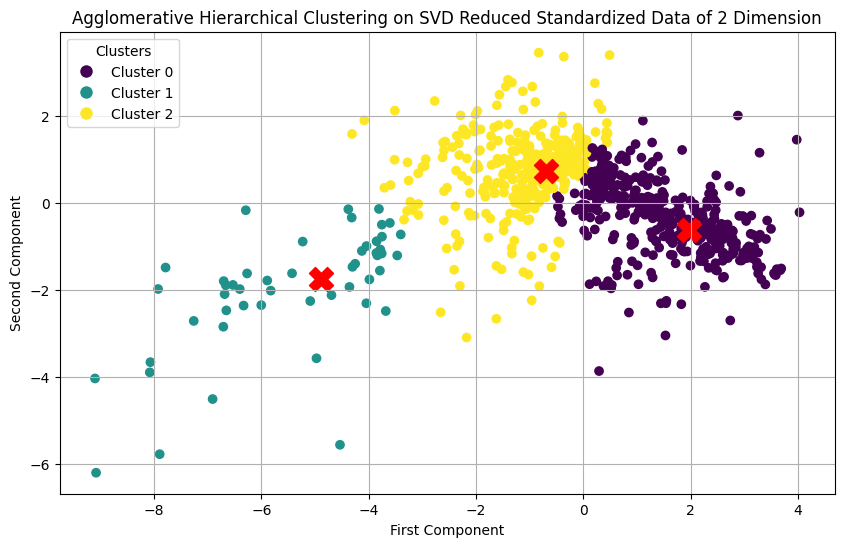

In [27]:
# Plot the scatterplot with the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=hierarchical_cluster, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=300, label='Centroids')

handles = []
for i in range(3):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                   markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10))

plt.title('Agglomerative Hierarchical Clustering on SVD Reduced Standardized Data of 2 Dimension')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

In [28]:
# Compute the Silhouette score
silhouette_score(X_reduced2, hierarchical_cluster)

np.float64(0.45391917433505463)

## Analysis of Clusters
We will analyse the clusters based on the K-Means clustering with the reduced standardized features in 2 dimensions, in an attempt to understand the natural grouping of Pokémon.

In [29]:
# Include the cluster determined from the K-Means clustering into the dataset
df['Cluster'] = kmeans_clusters

### Analysis of clusters on primary type

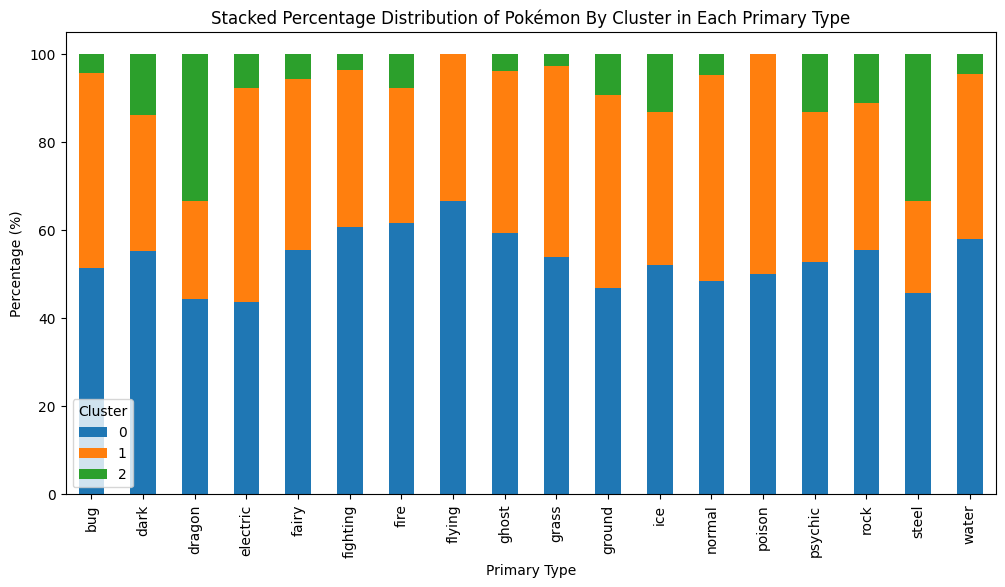

In [30]:
# Calculate the percentage of Pokémon by cluster in each primary type
type_counts = df.groupby(['Cluster', 'type1']).size().reset_index(name='Count')
total_counts = type_counts.groupby('type1')['Count'].transform('sum')
type_counts['Percentage'] = type_counts['Count']/total_counts*100
pivot_table = type_counts.pivot(index='type1', columns='Cluster', values='Percentage').fillna(0)

# Plot stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Percentage Distribution of Pokémon By Cluster in Each Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Cluster')
plt.show()

In [31]:
# Perform the Chi-Squared test between Cluster and Primary Type
contingency_table = pd.crosstab(df['Cluster'], df['type1'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}") # <0.5: reject null hypothesis, there is a significant association

Chi-squared statistic: 72.00764751387824
P-value: 0.00015317883418498285


### Analysis of clusters on height, weight, hp and speed

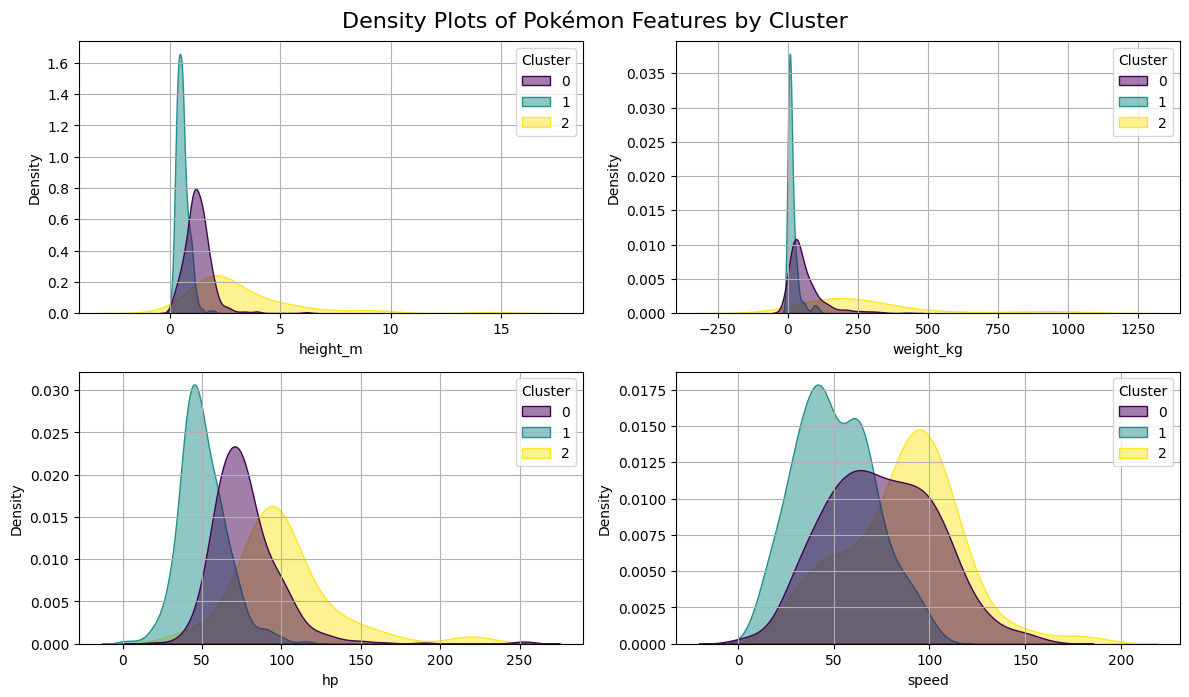

In [32]:
# Plot density for each feature across clusters
plotfeatures = ['height_m', 'weight_kg', 'hp', 'speed']
num_features = len(plotfeatures)
plt.figure(figsize=(12, 10))

for i, feature in enumerate(plotfeatures):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(data=df, x=feature, hue='Cluster', fill=True, alpha=0.5, common_norm=False, palette='viridis')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid()

plt.suptitle('Density Plots of Pokémon Features by Cluster', fontsize=16)
plt.tight_layout()
plt.subplots_adjust()  
plt.show()

### Analysis of clusters on attack and defense

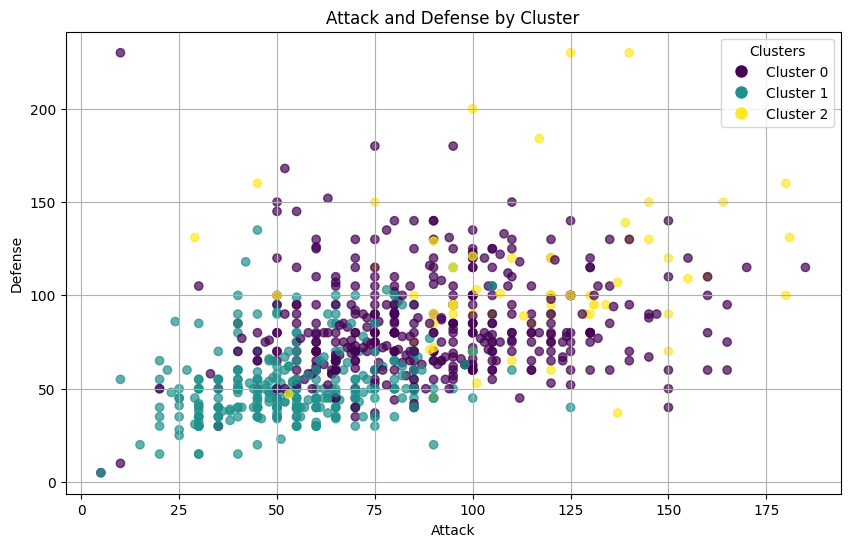

In [33]:
# Plot scatterplot with attack and defense
plt.figure(figsize=(10, 6))
plt.scatter(x="attack", y="defense", data=df, c=kmeans_clusters, cmap='viridis', marker='o', alpha=0.7)
plt.title('Attack and Defense by Cluster')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

### Analysis of clusters on capture rate and base egg steps

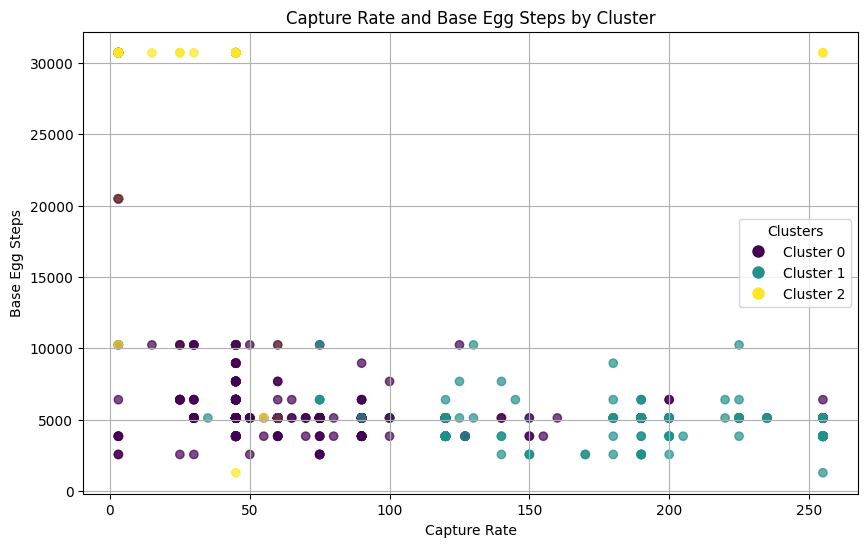

In [34]:
# Plot scatterplot with capture rate and base egg steps
plt.figure(figsize=(10, 6))
plt.scatter(x="capture_rate", y="base_egg_steps", data=df, c=kmeans_clusters, cmap='viridis', marker='o', alpha=0.7)
plt.title('Capture Rate and Base Egg Steps by Cluster')
plt.xlabel('Capture Rate')
plt.ylabel('Base Egg Steps')
plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

### Analysis of clusters on legendary type

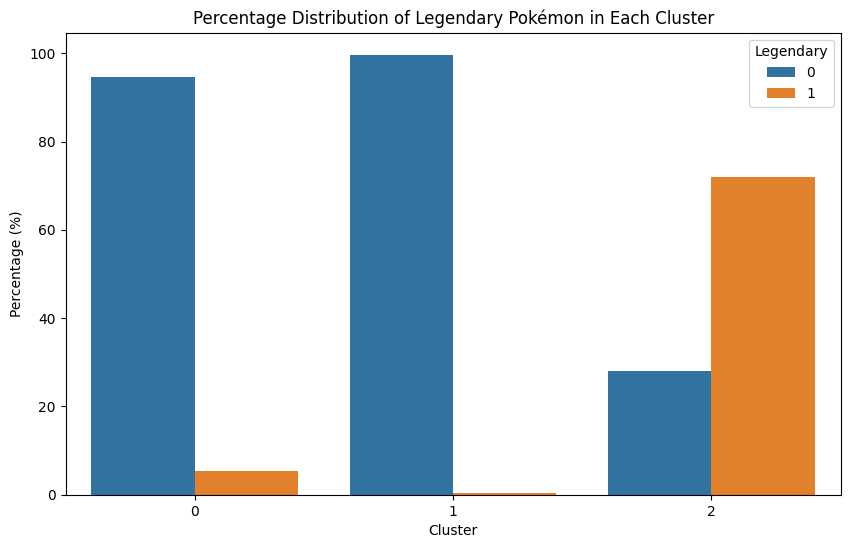

In [35]:
# Calculate the percentage of Pokémon by legendary type in each cluster
type_counts = df.groupby([ 'is_legendary','Cluster']).size().reset_index(name='Count')
total_counts = type_counts.groupby('Cluster')['Count'].transform('sum')
type_counts['Percentage'] = type_counts['Count']/total_counts * 100

# Plot barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=type_counts, x='Cluster', y='Percentage', hue='is_legendary')
plt.title('Percentage Distribution of Legendary Pokémon in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage (%)')
plt.legend(title='Legendary')
plt.show()